In [1]:
import os
data_dir = './drive/MyDrive/cakd5_colab/m9_딥러닝알고리즘구현/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [10]:
lines[:2]

['01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30',
 '01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10']

In [2]:
len(header)

15

In [3]:
# 넘파이 배열로 변환
import numpy as np

float_data = np.zeros((len(lines),len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  float_data[i,:] = values


In [4]:
float_data.shape

(420551, 14)

In [5]:
float_data[:,1]

array([-8.02, -8.41, -8.51, ..., -3.16, -4.23, -4.82])

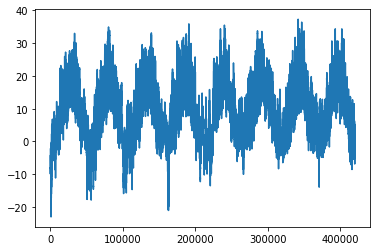

In [8]:
import matplotlib.pyplot as plt

temp = float_data[:,1]
plt.plot(range(len(temp)),temp)
plt.show()

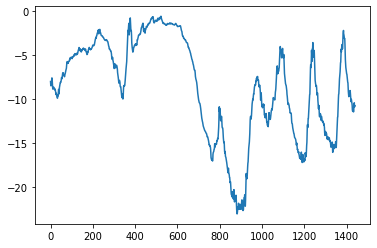

In [9]:
plt.plot(range(1440), temp[:1440])
plt.show()

In [16]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
float_data[:200000].std(axis=0)
float_data /= std

In [14]:
print(float_data[:,1].mean())
print(float_data[:,1].std())

0.04211222174014497
0.9515228544484235


이 제너레이터 함수는 다음과 같은 매개변수가 있습니다:

* `data` : 코드 6-32에서 정규화한 부동 소수 데이터로 이루어진 원본 배열
* `lookback` : 입력으로 사용하기 위해 거슬러 올라갈 타임스텝
* `delay` : 타깃으로 사용할 미래의 타임스텝
* `min_index`와 `max_index` : 추출할 타임스텝의 범위를 지정하기 위한 `data` 배열의 인덱스. 검증 데이터와 테스트 데이터를 분리하는 데 사용합니다.
* `shuffle` : 샘플을 섞을지 시간 순서대로 추출할지 결정합니다.
* `batch_size` : 배치의 샘플 수
* `step` : 데이터를 샘플링할 타임스텝 간격. 한 시간에 하나의 데이터 포인트를 추출하기 위해 6으로 지정하겠습니다.
* steps_per_epoch * batch_size = 훈련 샘플 수


In [17]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets


In [19]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 0,
                      max_index = 200000,
                      shuffle = True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 200001,
                      max_index = 300000,
                      shuffle = True,
                      step=step,
                      batch_size=batch_size)
test_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 300001,
                      max_index = None,
                      shuffle = True,
                      step=step,
                      batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000- 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
val_steps = (len(float_data) - 300001 - lookback) // batch_size

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data = val_gen,
                    validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 11s 21ms/step - loss: 1.0689 - val_loss: 0.4436
Epoch 2/20
500/500 [==============================] - 10s 21ms/step - loss: 0.3621 - val_loss: 0.3848
Epoch 3/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2816 - val_loss: 0.3132
Epoch 4/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2626 - val_loss: 0.3166
Epoch 5/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2503 - val_loss: 0.3019
Epoch 6/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2437 - val_loss: 0.3094
Epoch 7/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2368 - val_loss: 0.3652
Epoch 8/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2334 - val_loss: 0.3149
Epoch 9/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2285 - val_loss: 0.3174
Epoch 10/20
500/500 [==============================] - 11s 21ms/step - loss: 0.224

In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 3360)              0         
                                                                 
 dense_2 (Dense)             (None, 32)                107552    
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________


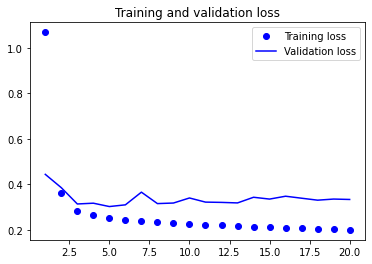

In [35]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [37]:
test_loss = model.evaluate_generator(test_gen,steps=6)
test_loss

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


0.5750107169151306

결과는 상식적인 수준의 기준점인 MAE 0.29 보다 좋지 않다. 그 이유는 해당 모델이 핵심 정보를 찾지 못했기 때문이며 즉 시계열 데이터를 펼쳤기 때문에 시간 개념을 잃어 버렸다.

[과제] 상기 문제를 해결하기 위하여 순환 시퀀스 처리 모델을 적용하여 데이터 포인트의 시간 순서를 사용하여 과제를 수행하세요.(LSTM, GRU) 

[과제]과대적합을 줄이기 위한 방법을 수행하세요.
- 순환 드롭아웃
- 스태킹 순환 층
- 양방향 RNN 사용